In [1]:
import os
from keras import applications
from keras import models
from keras import layers
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, Activation, GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras import regularizers
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.utils.np_utils import to_categorical 
from keras.callbacks import ModelCheckpoint
from keras.preprocessing import image
from keras import Model
from keras import initializers
from keras.callbacks import LearningRateScheduler
from keras.utils import layer_utils, np_utils
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.datasets import make_classification
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from classification_models import ResNet18
from classification_models.resnet import preprocess_input as resnet_preprocess_input
from keras.applications.densenet import preprocess_input as densenet_preprocess_input
from keras.applications.vgg16 import preprocess_input as vgg_preprocess_input
from sklearn.cross_validation import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from sklearn.utils import class_weight
import seaborn as sn
import pandas as pd
from scipy import interp
from itertools import cycle
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix
from sklearn.externals import joblib

Using TensorFlow backend.
c:\users\hp\appdata\local\programs\python\python36\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
image_width = 224
image_height = 224

# Change the batchsize according to your system RAM
batch_size = 64

train_dir = "D:/retinal_data_set_visioncare/New_Train_Test_Data/train/"
test_dir = "D:/retinal_data_set_visioncare/New_Train_Test_Data/test/"

feature_scaler_filename = "D:/retinal_data_set_visioncare/Image_Retrieval/feature_scaler.save"
svd_scaler_file_name = "D:/retinal_data_set_visioncare/Image_Retrieval/svd_scaler.save"

densenet_base = applications.DenseNet201(weights='imagenet', include_top=False, input_shape=(image_width, image_height, 3))
resnet_base = ResNet18(weights='imagenet', include_top=False, input_shape=(image_width, image_height, 3))
vgg_base = applications.VGG16(weights='imagenet', include_top=False, input_shape=(image_width, image_height, 3))

In [3]:
densenet_x = densenet_base.get_layer(index=-1).output
densenet_feature_extraction_layer = GlobalAveragePooling2D()(densenet_x)
densenet_model = Model(inputs=densenet_base.input, outputs=densenet_feature_extraction_layer)
densenet_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
__________________________________________________________________________________________________
conv1/relu

In [4]:
resnet_x = resnet_base.get_layer(index=-1).output
resnet_feature_extraction_layer = GlobalAveragePooling2D()(resnet_x)
resnet_model = Model(inputs=resnet_base.input, outputs=resnet_feature_extraction_layer)
resnet_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 224, 224, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_3 (ZeroPadding2D (None, 230, 230, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 112, 112, 64) 9408        zero_padding2d_3[0][0]           
__________________________________________________________________________________________________
bn0 (Batch

In [5]:
vgg_x = vgg_base.get_layer(index=-1).output
vgg_feature_extraction_layer = GlobalAveragePooling2D()(vgg_x)
vgg_model = Model(inputs=vgg_base.input, outputs=vgg_feature_extraction_layer)
vgg_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [6]:
class_labels = os.listdir(train_dir)

In [ ]:
# image_features_loc = 'D:/retinal_data_set_visioncare/Image_Retrieval/img_features.csv'
# create_traditional_features(train_dir, image_features_loc)

In [7]:
def generate_XY(data_dir, size=224):
    combined_feature_list = []
    labels = []

    for idx, level in enumerate(class_labels):
        retina_root = data_dir + level + '/'
        retina_root_list = os.listdir(retina_root)

        for index, relative_path in enumerate(retina_root_list):
            if relative_path == 'Thumbs.db':
                continue
            source = retina_root + relative_path
            img = image.load_img(source, target_size=(image_width, image_height))
            img_x = image.img_to_array(img)
            img_x = np.expand_dims(img_x, axis=0)
            
            # densenet201 - feature extraction
            densenet201_x = densenet_preprocess_input(img_x)
            densenet201_extract_features = densenet_model.predict(densenet201_x)
            flattern_feature_vector = densenet201_extract_features.flatten()
            
            # resnet18 - feature extraction
            resnet18_x = resnet_preprocess_input(img_x)
            resnet18_extract_features = resnet_model.predict(resnet18_x)
            resnet18_feature_vector = resnet18_extract_features.flatten()
            
            # vgg16 - feature extraction
            vgg16_x = vgg_preprocess_input(img_x)
            vgg16_extract_features = vgg_model.predict(vgg16_x)
            vgg16_feature_vector = vgg16_extract_features.flatten()

            flattern_feature_vector = np.concatenate((flattern_feature_vector, resnet18_feature_vector, vgg16_feature_vector))
            combined_feature_list.append(flattern_feature_vector)
            labels.append(int(level))
            
    return np.array(combined_feature_list), np.array(labels)
    

In [8]:
train_data, train_data_labels = generate_XY(train_dir)
test_data, test_data_labels = generate_XY(test_dir)

In [9]:
# Feature Scaling - fature normalizing
scaler = StandardScaler()
X_train = scaler.fit_transform(train_data)
# X_test = scaler.transform(test_data)

# scaler_filename = "scaler.save"
joblib.dump(scaler, feature_scaler_filename)

# # And now to load...

# scaler = joblib.load(feature_scaler_filename) 

['D:/retinal_data_set_visioncare/Image_Retrieval/feature_scaler.save']

In [10]:
# Make sparse matrix
X_sparse = csr_matrix(X_train)

In [11]:
# Run Truncated Singular Value Decomposition
# Create and run an TSVD with one less than number of features
tsvd = TruncatedSVD(n_components=X_sparse.shape[1]-1)
X_tsvd = tsvd.fit(X_train)

In [12]:
# list of explained variance ratios
# List of explained variances
tsvd_var_ratios = tsvd.explained_variance_ratio_
cum_var_exp = np.cumsum(tsvd_var_ratios)

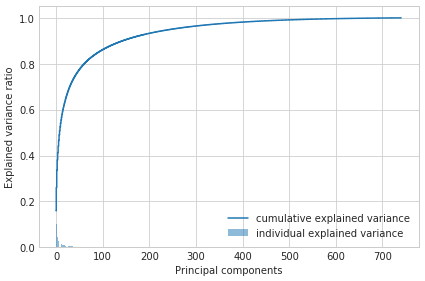

In [13]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 4))

    plt.bar(range(len(tsvd_var_ratios)), tsvd_var_ratios, alpha=0.5, align='center',
            label='individual explained variance')
    plt.step(range(len(cum_var_exp)), cum_var_exp, where='mid',
             label='cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.tight_layout()

In [14]:
# Create Function Calculating Number Of Components Required To Pass Threshold
def select_n_components(var_ratio, goal_var: float) -> int:
    # Set initial variance explained so far
    total_variance = 0.0
    
    # Set initial number of features
    n_components = 0
    
    # For the explained variance of each feature:
    for explained_variance in var_ratio:
        
        # Add the explained variance to the total
        total_variance += explained_variance
        
        # Add one to the number of components
        n_components += 1
        
        # If we reach our goal level of explained variance
        if total_variance >= goal_var:
            # End the loop
            break
            
    # Return the number of components
    return n_components

In [15]:
# Run function
number_of_components = select_n_components(tsvd_var_ratios, 0.95)

In [16]:
number_of_components

248

In [34]:
truncated_opt_svd = TruncatedSVD(n_components=number_of_components, random_state=42)
transformed_X_train = truncated_opt_svd.fit_transform(X_train)
#transformed_X_test = truncated_opt_svd.transform(X_test)
joblib.dump(truncated_opt_svd, svd_scaler_file_name)

['D:/retinal_data_set_visioncare/Image_Retrieval/svd_scaler.save']

In [19]:
# transformed_X_train
# train_data_labels

In [18]:
class_weight = class_weight.compute_class_weight('balanced'
                                               ,np.unique(train_data_labels)
                                               ,train_data_labels)

In [19]:
class_weight_dic = dict(enumerate(class_weight))

In [20]:
class_weight_dic

{0: 0.37236180904522614,
 1: 1.5278350515463917,
 2: 1.2453781512605042,
 3: 2.9058823529411764,
 4: 1.95}

In [21]:
# Returns a compiled model identical to the previous one
loaded_pretrained_deep_feature_model = load_model('D:/retinal_data_set_visioncare/models/ensemble/densenet_deep_feature_with_SVD_dr.h5')

In [22]:
loaded_pretrained_deep_feature_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 128)               31872     
_________________________________________________________________
batch_normalization_25 (Batc (None, 128)               512       
_________________________________________________________________
activation_25 (Activation)   (None, 128)               0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 5)                 645       
_________________________________________________________________
batch_normalization_26 (Batc (None, 5)                 20        
_________________________________________________________________
activation_26 (Activation)   (None, 5)                 0         
Total para

In [23]:
feature_extraction_layer = loaded_pretrained_deep_feature_model.get_layer('activation_25').output
#feature_extraction_layer = GlobalAveragePooling2D()(x)
feature_extract_model = Model(inputs=loaded_pretrained_deep_feature_model.input, outputs=feature_extraction_layer)
feature_extract_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25_input (InputLayer)  (None, 248)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 128)               31872     
_________________________________________________________________
batch_normalization_25 (Batc (None, 128)               512       
_________________________________________________________________
activation_25 (Activation)   (None, 128)               0         
Total params: 32,384
Trainable params: 32,128
Non-trainable params: 256
_________________________________________________________________


In [24]:
np.array([transformed_X_train[0]])

array([[ 4.31977577e+01,  1.22467947e+00,  8.32362556e+00,
         1.00992165e+01, -1.64809442e+00,  6.61522579e+00,
        -7.61827898e+00, -8.46329975e+00, -1.56798792e+00,
        -2.75159001e+00,  3.49437141e+00,  6.16113472e+00,
        -7.32622671e+00,  3.64598346e+00, -1.47498095e+00,
         3.06134963e+00,  2.22641245e-01, -4.06973791e+00,
         4.00197119e-01,  4.44825315e+00,  1.95196617e+00,
         2.48088789e+00, -6.57922551e-02, -2.63860846e+00,
        -4.97939253e+00, -3.93788671e+00, -1.92039633e+00,
         1.38276005e+00,  1.01253688e+00,  2.30557179e+00,
        -1.33028817e+00, -4.48285246e+00,  2.25172544e+00,
         1.06753445e+00, -1.28559482e+00,  2.89387673e-01,
         7.95740902e-01,  3.44673228e+00,  1.56418025e+00,
         1.13047421e+00, -1.42898536e+00,  1.41078758e+00,
        -9.19092476e-01, -2.10213375e+00, -3.80802298e+00,
         3.24905658e+00,  1.32624984e+00,  4.99307990e-01,
         4.11494398e+00, -6.42915249e-01,  1.78067231e+0

In [48]:
compressed_feature_list = []
for i, fname in enumerate(transformed_X_train):
    transformed_np_array = np.array([transformed_X_train[i]])
    ensemble_compressed_feature = feature_extract_model.predict(transformed_np_array)
    ensemble_compressed_feature_np = np.array(ensemble_compressed_feature)
    compressed_feature_list.append(ensemble_compressed_feature_np.flatten())

compressed_feature_list = np.array(compressed_feature_list)

In [49]:
X = compressed_feature_list
Y = train_data_labels

In [52]:
X.shape[1]

128

In [53]:
# define 5-fold cross validation test harness
#kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
kfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=25)
cvscores = []
trainScores = []
f1Score = []
num_k_folds = 5
fold_counter = 0
val_conmats = []
val_precisions = []
val_recalls = []
val_f_scores = []
input_dim = X.shape[1]

deep_hash_model = Sequential()
deep_hash_model.add(Dense(28, input_dim=input_dim, kernel_initializer=initializers.he_normal(seed=None), kernel_regularizer=regularizers.l2(0.001)))
deep_hash_model.add(BatchNormalization())
deep_hash_model.add(Activation('sigmoid'))
#cross_model.add(Dropout(0.8))
deep_hash_model.add(Dense(5, kernel_initializer=initializers.he_normal(seed=None), kernel_regularizer=regularizers.l2(0.001), activity_regularizer=regularizers.l2(0.001)))
deep_hash_model.add(BatchNormalization())
deep_hash_model.add(Activation('softmax'))

deep_hash_model.compile(optimizer=optimizers.SGD(lr=1e-3, momentum=0.9),
              loss='categorical_crossentropy',
              metrics=['acc'])

In [54]:
for train, test in kfold.split(X, Y):
    # Fit the model
    deep_hash_model.fit(X[train], to_categorical(Y[train]), epochs=400, batch_size=batch_size, class_weight=class_weight_dic, verbose=0)
    
    y_train_pred = deep_hash_model.predict(X[train])
    y_train_pred = np.argmax(y_train_pred, axis=1)
    
    y_validation_pred = deep_hash_model.predict(X[test])
    y_validation_pred = np.argmax(y_validation_pred, axis=1)
    #y_validation_pred = np.argmax(y_validation_pred, axis=1)
    
    [precision, recall, f_score, _] = precision_recall_fscore_support(Y[test], y_validation_pred)
    #print("Validation k-fold #%d - precision: %f, recallL: %f, f-score: %f" % (fold_counter, precision, recall, f_score))
    
    conmat = confusion_matrix(Y[test], y_validation_pred)
    
    val_precisions.append(precision)
    val_recalls.append(recall)
    val_f_scores.append(f_score)
    val_conmats.append(conmat)
    fold_counter = fold_counter + 1
    
    trainScores.append(accuracy_score(Y[train], y_train_pred))
    cvscores.append(accuracy_score(Y[test], y_validation_pred))
    
print("\nAveraging the 5-fold results:")
print("%s: %.2f%%" % ('AVG Train Acc ', np.mean(trainScores) * 100))
print("%s: %.2f%%" % ('AVG Validation Acc ', np.mean(cvscores) * 100))
print("Validation precision - mean: %f, stddev: %f" % (np.mean(val_precisions), np.std(val_precisions)))
print("Validation recall - mean: %f, stddev: %f" % (np.mean(val_recalls), np.std(val_recalls)))
print("Validation f-score - mean: %f, stddev: %f" % (np.mean(val_f_scores), np.std(val_f_scores)))
print("Confusion matrix:")
print (sum(val_conmats).astype(float) / fold_counter)


Averaging the 5-fold results:
AVG Train Acc : 100.00%
AVG Validation Acc : 100.00%
Validation precision - mean: 1.000000, stddev: 0.000000
Validation recall - mean: 1.000000, stddev: 0.000000
Validation f-score - mean: 1.000000, stddev: 0.000000
Confusion matrix:
[[79.6  0.   0.   0.   0. ]
 [ 0.  19.4  0.   0.   0. ]
 [ 0.   0.  23.8  0.   0. ]
 [ 0.   0.   0.  10.2  0. ]
 [ 0.   0.   0.   0.  15.2]]


In [26]:
# Save the model
deep_hash_model.save('D:/retinal_data_set_visioncare/Image_Retrieval/deep_hash_model.h5')

In [36]:
# # Returns a compiled model identical to the previous one
# loaded_deep_hash_model = load_model('D:/retinal_data_set_visioncare/Image_Retrieval/deep_hash_model.h5')
# loaded_deep_hash_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 28)                3612      
_________________________________________________________________
batch_normalization_5 (Batch (None, 28)                112       
_________________________________________________________________
activation_5 (Activation)    (None, 28)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 5)                 145       
_________________________________________________________________
batch_normalization_6 (Batch (None, 5)                 20        
_________________________________________________________________
activation_6 (Activation)    (None, 5)                 0         
Total params: 3,889
Trainable params: 3,823
Non-trainable params: 66
_________________________________________________________________


In [28]:
############################################## Image Retrieval Database ###############################################
a = np.array([5, 6, 7, 8])
df = pd.DataFrame({"a": [a]})

In [33]:
np.array([a])

array([[5, 6, 7, 8]])

In [31]:
df['a'][0]

array([5, 6, 7, 8])

In [38]:
# hashcode_extraction_layer = loaded_deep_hash_model.get_layer('activation_5').output
# #feature_extraction_layer = GlobalAveragePooling2D()(x)
# hashcode_extract_model = Model(inputs=loaded_deep_hash_model.input, outputs=hashcode_extraction_layer)
# hashcode_extract_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7_input (InputLayer)   (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 28)                3612      
Total params: 3,612
Trainable params: 3,612
Non-trainable params: 0
_________________________________________________________________


In [35]:
# norm_scaler = joblib.load(feature_scaler_filename) 
# norm_truncated_opt_svd = joblib.load(svd_scaler_file_name) 

In [ ]:
# def create_traditional_features(data_dir, file_path):
#     COLUMN_NAMES=['img_path','deep_features','hash_code']
#     df = pd.DataFrame(columns=COLUMN_NAMES)
    
#     for idx, level in enumerate(class_labels):
#         retina_root = data_dir + level + '/'
#         retina_root_list = os.listdir(retina_root)

#         for index, relative_path in enumerate(retina_root_list):
#             if relative_path == 'Thumbs.db':
#                 continue
#             source = retina_root + relative_path
#             img = image.load_img(source, target_size=(image_width, image_height))
#             img_x = image.img_to_array(img)
#             img_x = np.expand_dims(img_x, axis=0)
            
#             # densenet201 - feature extraction
#             densenet201_x = densenet_preprocess_input(img_x)
#             densenet201_extract_features = densenet_model.predict(densenet201_x)
#             flattern_feature_vector = densenet201_extract_features.flatten()
            
#             # resnet18 - feature extraction
#             resnet18_x = resnet_preprocess_input(img_x)
#             resnet18_extract_features = resnet_model.predict(resnet18_x)
#             resnet18_feature_vector = resnet18_extract_features.flatten()
            
#             # vgg16 - feature extraction
#             vgg16_x = vgg_preprocess_input(img_x)
#             vgg16_extract_features = vgg_model.predict(vgg16_x)
#             vgg16_feature_vector = vgg16_extract_features.flatten()

#             flattern_feature_vector = np.concatenate((flattern_feature_vector, resnet18_feature_vector, vgg16_feature_vector))
#             scaled_flattern_feature_vector = norm_scaler.transform(np.array([flattern_feature_vector]))
#             transformed_flattern_feature_vector = norm_truncated_opt_svd.transform(scaled_flattern_feature_vector)
#             ensemble_compressed_feature = feature_extract_model.predict(transformed_flattern_feature_vector)
#             ensemble_compressed_feature_np = np.array(ensemble_compressed_feature)
            
#             ensemble_compressed_feature_np_arr = np.array(ensemble_compressed_feature_np.flatten())
#             # load feature extractor model for sigmoid layer model as a feature extractor
#             deep_hash_proba = hashcode_extract_model.predict(ensemble_compressed_feature_np_arr)
#             deep_hash_code = numpy.asarray([1 if val >= 0.5 else 0 for val in deep_hash_proba], dtype=numpy.int64)
#             df = df.append({'img_path': source, 'exact_deep_features': [ensemble_compressed_feature_np], 'hash_code': [deep_hash_code]}, ignore_index=True)
            
#     df.to_csv(file_path, encoding='utf-8', index=False)